In [61]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install -q captum

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

2.2.1


# Explaining GNN Model Predictions using Captum, GNNExplainer, and PGExplainer

Use ESOL dataset from MoleculeNet to train a GNN model for regression. We then explain the model predictions using Captum, GNNExplainer, and PGExplainer.

## Loading the dataset

We load the dataset and use 10% of the data as the test split and 10% as the validation split. The rest is used for training. We print some information about the dataset.

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset splits: train, valid, test:  903 113 112
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68
Atom types:  {'P', 'F', 'C', 'I', 'N', 'O', 'Cl', 'S', 'Br'}


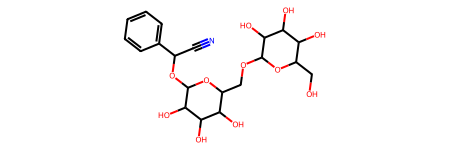

In [62]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset, MoleculeNet
import warnings
warnings.filterwarnings("ignore")

path = '.'
dataset = MoleculeNet('MoleculeNet', "ESOL")
test_dataset = dataset[:len(dataset) // 10]
valid_dataset = dataset[len(dataset) // 10:2 * len(dataset) // 10]
train_dataset = dataset[2 * len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

print("Dataset type: ", type(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print("Dataset splits: train, valid, test: ", len(train_dataset), len(valid_dataset), len(test_dataset))
print("Dataset sample: ", dataset[0])
print("Sample  nodes: ", dataset[0].num_nodes)
print("Sample  edges: ", dataset[0].num_edges)
# count atom types
atom_types = set()
for data in dataset:
    # check smiles
    molecule = Chem.MolFromSmiles(data["smiles"])
    for atom in molecule.GetAtoms():
        atom_types.add(atom.GetSymbol())
print("Atom types: ", atom_types)

molecule = Chem.MolFromSmiles(dataset[0]["smiles"])
molecule

## Visualizing the data

We define some utility functions for visualizing the molecules and draw a random molecule.

In [63]:
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx

atom_numbers_to_types = {
    17: 'Cl',
    8: 'O',
    35: 'Br',
    6: 'C',
    53: 'I',
    7: 'N',
    15: 'P',
    9: 'F',
    16: 'S',
}

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):

    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = atom_numbers_to_types[data['x'][0]]
        del data['x']
    return g


## Sample visualization

We sample a single molecule from train_dataset and visualize it

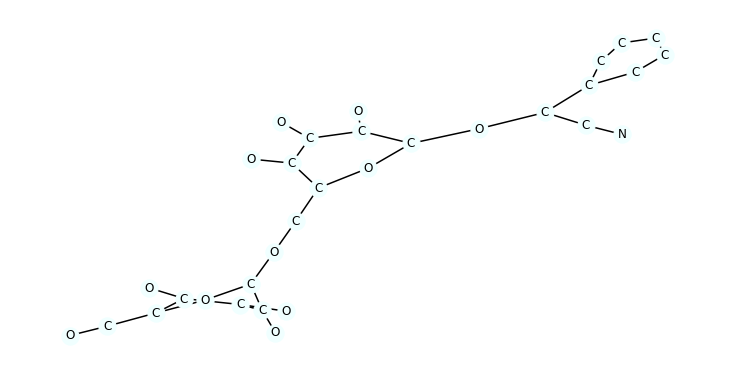

In [64]:
import random

data = dataset[0]
# print(data)
# print(data.x)
# print(data.y)
# count atom number from data["smiles"]
# molecule = Chem.MolFromSmiles(data["smiles"])
# get atom number
# atom_num = molecule.GetNumAtoms()
# print("Atom number: ", atom_num)

mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

## Training the model

In the next section, we train a GNN model with 5 convolution layers. We use GraphConv which supports `edge_weight` as a parameter. Many convolution layers in Pytorch Geometric supoort this argument.

### Define the model

In [65]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()
        torch.manual_seed(42)

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

class GCN(torch.nn.Module):
    def __init__(self, embedding_size=64):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index, edge_weight=None):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index, edge_weight)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index, edge_weight)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index, edge_weight)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index, edge_weight)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))


GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


### Define train and test functions

In [66]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.7, patience=5,
                                                       min_lr=1e-10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    losses = 0
    for batch in train_loader:
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad()
        # Passing the node features and the connection info
        pred = model(batch.x.float(), batch.edge_index, batch.batch)
        # Calculating the loss and gradients
        loss = loss_fn(pred, batch.y)
        loss.backward()
        # Update using the gradients
        optimizer.step()
        losses += loss
    return losses / len(train_loader)


def test(model, test_loader, loss_fn):
    model.eval()
    # regression task
    loss = 0
    for batch in test_loader:
        batch.to(device)
        pred = model(batch.x.float(), batch.edge_index, batch.batch)
        loss += loss_fn(pred, batch.y)
    return loss / len(test_loader)


### Train the model for 100 epochs


Starting training...
Epoch 10 | Train Loss 5.798709392547607 | Valid Loss 5.880218029022217
Epoch 20 | Train Loss 4.072356700897217 | Valid Loss 4.739797592163086
Epoch 30 | Train Loss 4.00624418258667 | Valid Loss 4.752080917358398
Epoch 40 | Train Loss 3.994264602661133 | Valid Loss 4.744027137756348
Epoch 50 | Train Loss 3.9863202571868896 | Valid Loss 4.73681116104126
Epoch 60 | Train Loss 3.9786651134490967 | Valid Loss 4.729648590087891
Epoch 70 | Train Loss 3.9695661067962646 | Valid Loss 4.721446990966797
Epoch 80 | Train Loss 3.958782196044922 | Valid Loss 4.712104320526123
Epoch 90 | Train Loss 3.945984363555908 | Valid Loss 4.70110559463501
Epoch 100 | Train Loss 3.9307608604431152 | Valid Loss 4.6884660720825195
Epoch 110 | Train Loss 3.9130687713623047 | Valid Loss 4.674276351928711
Epoch 120 | Train Loss 3.892910957336426 | Valid Loss 4.658530235290527
Epoch 130 | Train Loss 3.870253324508667 | Valid Loss 4.641404628753662
Epoch 140 | Train Loss 3.84493350982666 | Valid L

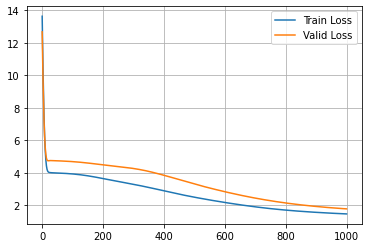

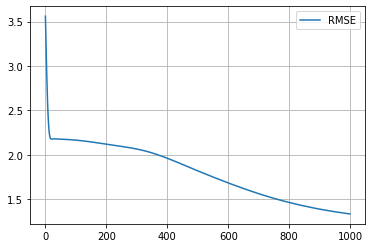

In [67]:
print("Starting training...")
train_losses = []
valid_losses = []
RMSE = []
for epoch in range(1, 1001):
    loss = train(model, train_loader, optimizer, loss_fn)
    train_losses.append(loss)
    # valid
    valid_loss = test(model, valid_loader, loss_fn)
    valid_losses.append(valid_loss)
    scheduler.step(valid_loss)
    RMSE.append(np.sqrt(valid_loss.detach().numpy()))

    if epoch % 10 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch} | Train Loss {loss} | Valid Loss {valid_loss} | LR {lr}")

train_losses = [float(loss.cpu().detach().numpy()) for loss in train_losses]
valid_losses = [float(loss.cpu().detach().numpy()) for loss in valid_losses]

plt.plot(train_losses, label="Train Loss")

plt.plot(valid_losses, label="Valid Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(RMSE, label="RMSE")
plt.legend()
plt.grid()
plt.show()


## Explaining the predictions

Now we look at two popular attribution methods. First, we calculate the gradient of the output with respect to the edge weights $w_{e_i}$. Edge weights are initially one for all edges.
For the saliency method, we use the absolute value of the gradient as the attribution value for each edge:

$$
Attribution_{e_i} = |\frac{\partial F(x)}{\partial w_{e_i}}|
$$

Where $x$ is the input and $F(x)$ is the output of the GNN model on input $x$.

For Integrated Gradients method, we interpolate between the current input and a baseline input where the weight of all edges is zero and accumulate the gradient values for each edge:

$$
Attribution_{e_i} = \int_{\alpha =0}^1 \frac{\partial F(x_{\alpha)}}{\partial w_{e_i}} d\alpha
$$

Where $x_{\alpha}$ is the same as the original input graph but the weight of all edges is set to $\alpha$. Integrated Gradients complete formulation is more complicated but since our initial edge weights are equal to one and the baseline is zero, it can be simplified to the formulation above. You can read more about this method [here](https://arxiv.org/abs/1703.01365). Of course, this can not be calculated directly and is approximated by a discrete sum.

We use the [captum](https://captum.ai/) library for calculating the attribution values. We define the `model_forward` function which calculates the `batch` argument assuming that we are only explaining a single graph at a time.



In [68]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x.float(), data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

Finally we take a random sample from the test dataset and run the explanation methods. For a simpler visualization, we make the graph undirected and merge the explanations of each edge in both directions.

It is known that NO2 substructure makes the molecules mutagenic in many cases and you can verify this by the model explanations.

Mutagenic molecules have label 0 in this dataset and we only sample from those molecules but you can change the code and see the explanations for the other class as well.

In this visualization, edge colors and thickness represent the importance. You can also see the numeric value by passing `draw_edge_labels` to `draw_molecule` function.

As you can see Integrated Gradients tend to create more accurate explanations.

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])


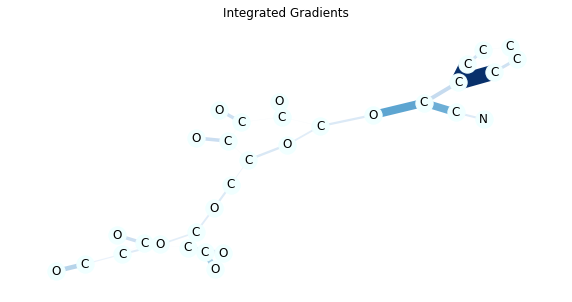

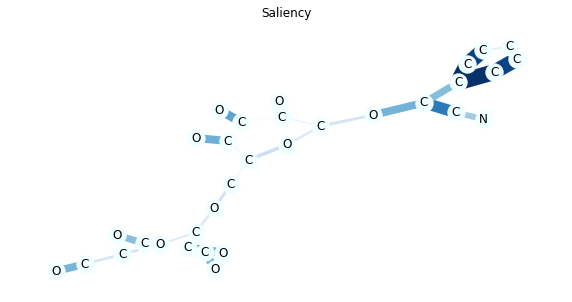

In [69]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


data = dataset[0]
print(data)
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Original molecule


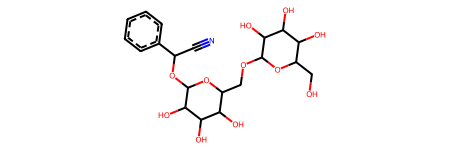

--------------------------------------------------
Explanation for Integrated Gradients


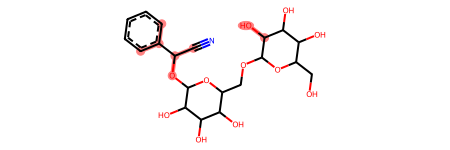

--------------------------------------------------
Explanation for Saliency


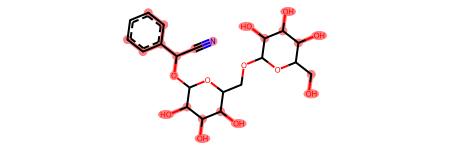

--------------------------------------------------


In [92]:
# visualize the explanation using rdKit
# add an important edge to the molecule: Draw.MolToImage(mols[0], size=(450, 150)) Draw.MolToImage(mols[0], kekulize=False, size=(450, 150), highlightAtoms=[2], highlightBonds=[0])
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole


def draw_molecule_rdkit(mol, edge_mask_dict, threshold=0.5):
    # highlight the important edges with a threshold
    highlightBonds = []
    highlightAtoms = []
    for (u, v), val in edge_mask_dict.items():
        if val > threshold:
            bond = mol.GetBondBetweenAtoms(u, v)
            highlightBonds.append(bond.GetIdx())
            highlightAtoms.append(u)
            highlightAtoms.append(v)

    img = Draw.MolToImage(mol, kekulize=False, size=(450, 150), highlightAtoms=highlightAtoms, highlightBonds=highlightBonds)
    return img

data = dataset[0]
print(data)
molecule = Chem.MolFromSmiles(dataset[0]["smiles"])
img = draw_molecule_rdkit(molecule, {})
print("Original molecule")
display(img)
print('-'*50)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    print(f"Explanation for {title}")
    img = draw_molecule_rdkit(molecule, edge_mask_dict)
    display(img)
    print('-'*50)

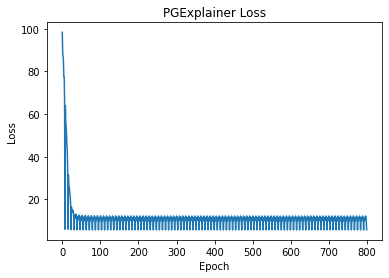

In [70]:
from torch_geometric.explain import Explainer, PGExplainer


pgexplainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=100, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    # Include only the top 10 most important edges:
    threshold_config=dict(threshold_type='topk', value=10),
)

pg_loss = []
for epoch in range(100):
    for batch in train_loader:
        loss = pgexplainer.algorithm.train(
            epoch, model, batch.x.float(), batch.edge_index, target=batch.y, batch_index=batch.batch)
        pg_loss.append(loss)

plt.plot(pg_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PGExplainer Loss')
plt.show()

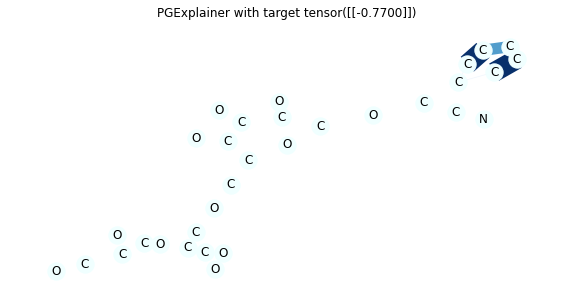

Edge mask:  defaultdict(<class 'float'>, {(0, 1): 0.0, (1, 2): 0.0, (2, 3): 0.0, (2, 30): 0.0, (3, 4): 0.0, (4, 5): 0.0, (4, 26): 0.0, (5, 6): 0.0, (6, 7): 0.0, (7, 8): 0.0, (7, 24): 0.0, (8, 9): 0.0, (9, 10): 0.0, (9, 20): 0.0, (10, 11): 0.0, (11, 12): 0.0, (11, 14): 0.0, (12, 13): 0.0, (14, 15): 0.06980988383293152, (14, 19): 0.06980988383293152, (15, 16): 1.9818410873413086, (16, 17): 1.1382834315299988, (17, 18): 1.1382834315299988, (18, 19): 1.9818410873413086, (20, 21): 0.0, (20, 22): 0.0, (22, 23): 0.0, (22, 24): 0.0, (24, 25): 0.0, (26, 27): 0.0, (26, 28): 0.0, (28, 29): 0.0, (28, 30): 0.0, (30, 31): 0.0})


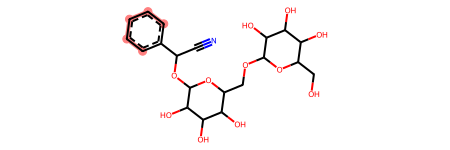

In [99]:
# Generate the explanation for a particular graph:
data = dataset[0]
explanation = pgexplainer(data.x.float(), data.edge_index, batch_index=dataset[0].batch, target=dataset[0].y)
# print(explanation.edge_mask)
# visualize the explanation
# convert the edge mask to a list
# normalize the edge mask
edge_mask_ = explanation.edge_mask
edge_mask_ = edge_mask_.numpy()
edge_mask_ = (edge_mask_ - edge_mask_.min()) / (edge_mask_.max() - edge_mask_.min())
edge_mask_ = edge_mask_.tolist()
edge_mask_dict = aggregate_edge_directions(edge_mask_, data)
plt.figure(figsize=(10, 5))
plt.title(f'PGExplainer with target {data.y}')
draw_molecule(mol, edge_mask_dict)

print("Edge mask: ", edge_mask_dict)

# visualize the explanation using rdKit
molecule = Chem.MolFromSmiles(data["smiles"])
img = draw_molecule_rdkit(molecule, edge_mask_dict)
display(img)


In [97]:
# Try GNNExplainer
from torch_geometric.explain import GNNExplainer

gnnexplainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    # Include only the top 10 most important edges:
    threshold_config=dict(threshold_type='topk', value=10),
)

# gnn_loss = []
# for epoch in range(100):
#     for batch in train_loader:
#         loss = gnnexplainer.algorithm.train(
#             epoch, model, batch.x.float(), batch.edge_index, target=batch.y, batch_index=batch.batch)
#         gnn_loss.append(loss)

# plt.plot(gnn_loss)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('GNNExplainer Loss')
# plt.show()

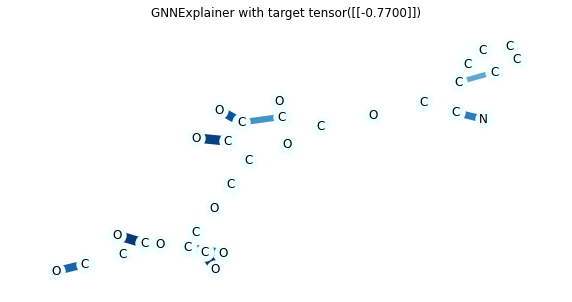

Edge mask:  defaultdict(<class 'float'>, {(0, 1): 0.7974936366081238, (1, 2): 0.0, (2, 3): 0.0, (2, 30): 0.0, (3, 4): 0.0, (4, 5): 0.0, (4, 26): 0.0, (5, 6): 0.0, (6, 7): 0.0, (7, 8): 0.0, (7, 24): 0.0, (8, 9): 0.0, (9, 10): 0.0, (9, 20): 0.0, (10, 11): 0.0, (11, 12): 0.0, (11, 14): 0.0, (12, 13): 0.7072932720184326, (14, 15): 0.0, (14, 19): 0.5275086164474487, (15, 16): 0.0, (16, 17): 0.0, (17, 18): 0.0, (18, 19): 0.0, (20, 21): 0.8115220665931702, (20, 22): 0.6207259893417358, (22, 23): 0.8660728335380554, (22, 24): 0.0, (24, 25): 0.9399265050888062, (26, 27): 1.0, (26, 28): 0.0, (28, 29): 0.7852786183357239, (28, 30): 0.0, (30, 31): 0.9585683941841125})


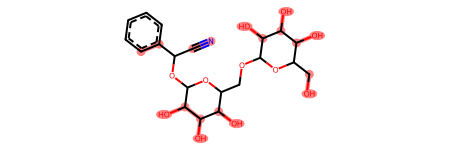

In [101]:
# visualize the explanation
# convert the edge mask to a list
# normalize the edge mask
explanation = gnnexplainer(data.x.float(), data.edge_index, batch_index=dataset[0].batch, target=dataset[0].y)
edge_mask_ = explanation.edge_mask
edge_mask_ = edge_mask_.numpy()
edge_mask_ = (edge_mask_ - edge_mask_.min()) / (edge_mask_.max() - edge_mask_.min())
edge_mask_ = edge_mask_.tolist()
edge_mask_dict = aggregate_edge_directions(edge_mask_, data)
plt.figure(figsize=(10, 5))
plt.title(f'GNNExplainer with target {data.y}')
draw_molecule(mol, edge_mask_dict)

print("Edge mask: ", edge_mask_dict)

# visualize the explanation using rdKit
molecule = Chem.MolFromSmiles(data["smiles"])
img = draw_molecule_rdkit(molecule, edge_mask_dict)
display(img)
